# 我们利用最简单的回归模型看一下上证综指的婴儿底到底在哪里。

In [4]:
import pandas.io.data as web
import datetime
import pandas as pd
import scipy
import numpy as np 
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda27_241\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [5]:

start = datetime.datetime(1992, 8, 12)
end = datetime.datetime(2016, 5, 20)

# 用下面的代码重新从yahoo抽取指数价格。
# If you want to run this notebook at your local instance, uncomment those lines of code and fetch the latest index from Yahoo again.
# Refer to:  http://pandas.pydata.org/pandas-docs/stable/remote_data.html
'''
shanghai = web.DataReader("000001.SS", 'yahoo', start, end)
shanghai.head()
shanghai.to_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
'''

# I saved and reloaded from this location as a cache for my testing purpose.
shanghai = pd.DataFrame.from_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
#print(shanghai.count())


In [6]:
# shanghai.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21
1992-08-13,850.94,850.94,850.94,850.94,0,850.94
1992-08-14,858.38,858.38,858.38,858.38,0,858.38
1992-08-17,939.46,939.46,939.46,939.46,0,939.46
1992-08-18,933.44,933.44,933.44,933.44,0,933.44


这里我们将把日期改成从开始的1992年开始到每一天的间隔天数"days"。然后我们可以简单看一下下载的数据结构，基本上世界上所有的股票都是监控这几个指标，其中我们将重点关注最低价格"Low"。

In [7]:

sh = shanghai.copy()
sh['date1'] = shanghai.index
#http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
sh['days'] = sh['date1'].apply(lambda x:  (x-start).days)
sh.head()

,Open,High,Low,Close,Volume,Adj Close,date1,days
Date,,,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21,1992-08-12,0
1992-08-13,850.94,850.94,850.94,850.94,0,850.94,1992-08-13,1
1992-08-14,858.38,858.38,858.38,858.38,0,858.38,1992-08-14,2
1992-08-17,939.46,939.46,939.46,939.46,0,939.46,1992-08-17,5
1992-08-18,933.44,933.44,933.44,933.44,0,933.44,1992-08-18,6


C:\Anaconda27_241\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


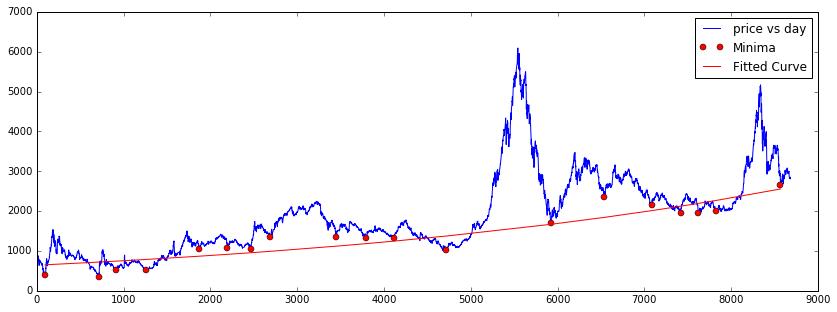

In [8]:

x_all = sh['days'].values
y_all = sh['Low'].values

# http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html
from scipy.signal import argrelextrema
local_min_ix =  argrelextrema(y_all, np.less,   order=100)

x_minima=x_all[local_min_ix]
y_minima=y_all[local_min_ix]

def exp_func(x, a, b, c):
    return a * np.exp(b * x)
popt_minima, pcov_minima = curve_fit(exp_func, x_minima, y_minima, p0=[ 5.69396441e+02,   1.93941219e-04,   2.25849076e+02])

plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b-', label="price vs day") 
plt.plot(x_minima, y_minima, 'ro', label="Minima") 
plt.plot(x_minima, exp_func(x_minima, *popt_minima), 'r-', label="Fitted Curve")
plt.legend()
plt.show()



In [9]:
x_minima

array([  97,  716,  909, 1258, 1868, 2196, 2470, 2693, 3450, 3796, 4115,
       4716, 5928, 6536, 7085, 7418, 7624, 7831, 8569], dtype=int64)

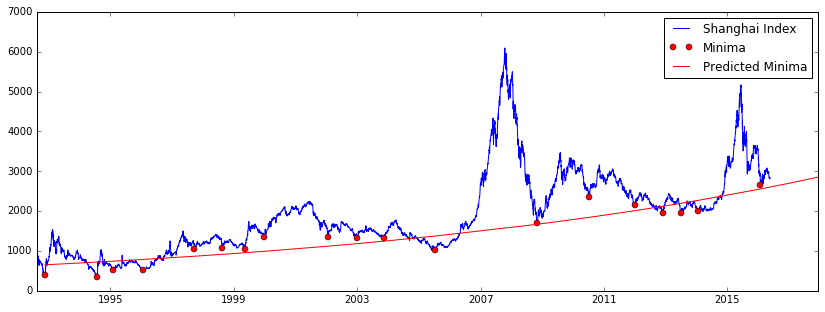

In [51]:
'''from datetime import datetime, timedelta

def add_start_date(a):
    days_add = int(a[0]) 
    print(start)
    print(days_add)
    # return datetime(1992, 8, 12)  +  timedelta(days=1) 
    return np.datetime64('1992-08-12') + np.timedelta64(days_add,'D') 

x_minima_date = np.apply_along_axis(add_start_date, 0, x_minima)
x_minima_date
'''
df = pd.DataFrame({'days': x_minima, 'predicted_low':exp_func(x_minima, *popt_minima) })
predicted_df = pd.merge(sh, df, on=['days','days'])

new_day = 8900
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9060
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9250
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 

plt.figure(figsize=(14,5))
plt.plot(sh['date1'].values, y_all, 'b-', label="Shanghai Index") 
plt.plot(predicted_df[predicted_df.date1<=end]['date1'].values, predicted_df[predicted_df.date1<=end]['Low'].values, 'ro', label="Minima") 
plt.plot(predicted_df['date1'].values, predicted_df['predicted_low'].values, 'r-', label="Predicted Low")
plt.legend()
plt.show()


In [59]:
predicted_df


,Open,High,Low,Close,Volume,Adj Close,date1,days,predicted_low,lower_bound,upper_bound
0,393.52,393.52,393.52,393.52,0,393.52,1992-11-17,97,652.277070,542.362867,884.298571
1,333.92,333.92,333.92,333.92,0,333.92,1994-07-29,716,720.693024,548.375144,894.101321
2,532.49,532.49,532.49,532.49,0,532.49,1995-02-07,909,743.458345,550.390463,897.387209
3,516.46,516.46,516.46,516.46,0,516.46,1996-01-22,1258,786.466071,554.217993,903.627827
4,1041.97,1041.97,1041.97,1041.97,0,1041.97,1997-09-23,1868,867.697545,561.520061,915.533525
5,1070.41,1070.41,1070.41,1070.41,0,1070.41,1998-08-17,2196,914.791498,565.797411,922.507555
6,1059.87,1059.87,1059.87,1059.87,0,1059.87,1999-05-18,2470,956.085868,569.574812,928.666438
7,1345.35,1345.35,1345.35,1345.35,0,1345.35,1999-12-27,2693,991.066166,572.794356,933.915761
8,1358.69,1358.69,1358.69,1358.69,0,1358.69,2002-01-22,3450,1119.639539,584.785258,953.466396
9,1319.87,1319.87,1319.87,1319.87,0,1319.87,2003-01-03,3796,1183.836251,590.865949,963.380692


In [60]:
std

0.23967543702333519

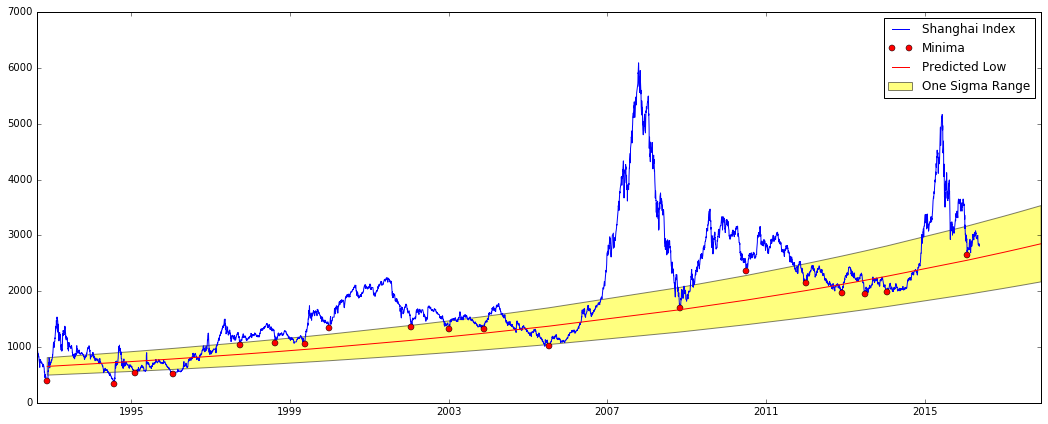

In [63]:
x_extended=np.append(  x_all[local_min_ix], [8900, 9000, 9100] )

# Generate some data for this demonstration.
data =( exp_func(x_minima, *popt_minima)-y_minima ) / exp_func(x_minima, *popt_minima)
# Fit a normal distribution to the data:
mu, std = scipy.stats.norm.fit(data)

# the 1 sigma upper and lower analytic population bounds
#lower_bound = exp_func(x_extended, *popt_minima)*(1-std)
#upper_bound = exp_func(x_extended, *popt_minima)*(1+std)

predicted_df['lower_bound'] = predicted_df['predicted_low'].values *(1-std)
predicted_df['upper_bound'] = predicted_df['predicted_low'].values *(1+std)

plt.figure(figsize=(18,7))
plt.plot(sh['date1'].values, y_all, 'b-', label="Shanghai Index") 
plt.plot(predicted_df[predicted_df.date1<=end]['date1'].values, predicted_df[predicted_df.date1<=end]['Low'].values, 'ro', label="Minima") 
plt.plot(predicted_df['date1'].values, predicted_df['predicted_low'].values, 'r-', label="Predicted Low")

plt.fill_between(predicted_df['date1'].values, 
                 predicted_df['lower_bound'].values, 
                 predicted_df['upper_bound'].values, 
                 facecolor='yellow', alpha=0.5, label='One Sigma Range')
plt.legend()
plt.show()

 

 Now we check a few statistics. According to 

In [14]:
print(exp_func(x_extended, *popt_minima))

[  652.27707024   720.69302351   743.45834529   786.46607064   867.69754532
   914.79149755   956.08586801   991.0661661   1119.6395393   1183.83625063
  1246.27980186  1373.01128148  1669.13326823  1840.9391305   2011.21717437
  2122.08426067  2193.70739527  2268.1133526   2554.52815785  2694.47642153
  2738.24612827  2782.72684039]


In [15]:
print(np.diff(x_minima))
print(np.amin(np.diff(x_minima)))

[ 619  193  349  610  328  274  223  757  346  319  601 1212  608  549  333
  206  207  738]
193


一个值如果低于1倍的Sigma，出现的概率是多少呢？大概是这个数：

In [53]:
scipy.stats.norm(mu, std).cdf(mu-std)

0.15865525393145707

In [17]:
## Then we know the expected low end of shanghai index as: 
print(exp_func(8700, *popt_minima)) 


2609.02474536


[Some answers from web](http://zhidao.baidu.com/question/347142653.html)
2001年至2010年十年间年平均交易日是240.8天。2010年的交易日是242天。不过由于周末与年的频率不一致，所以每年可能会由1天左右的上下浮动，所以比较准确的说法是(241±1)天。


In [18]:
print(popt_minima[1])
print(np.exp(240.8*popt_minima[1]))

0.000161137085168
1.03956443207


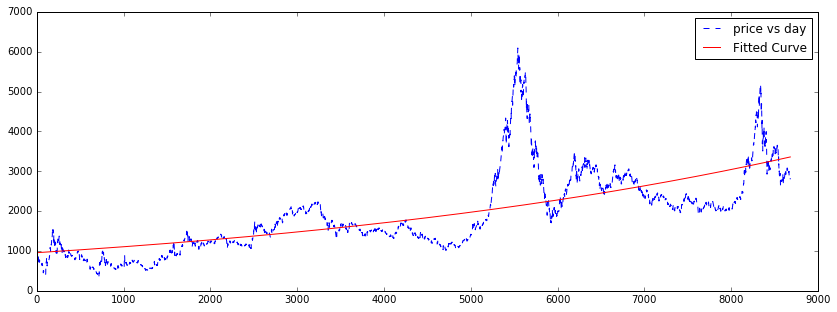

In [19]:
'''import random
rows = random.sample(sh.index, 30)
rows.sort()
sh_600 = sh.ix[rows]
'''

# Now use all data
#sh_600 =  


# print(x1.shape)

def exp_func(x, a, b, c):
    return a * np.exp(b * x)  
# p0=[100, 0.001, 900])
# ([  5.69396441e+02,   1.93941219e-04,   2.25849076e+02])
popt_all, pcov_all = curve_fit(exp_func, x_all, y_all, p0=[ 2.28786762e+04,   1.64695236e-05,  -2.23512090e+04])
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b--', label="price vs day") 
plt.plot(x_all, exp_func(x_all, *popt_all), 'r-', label="Fitted Curve")
plt.legend()
plt.show()


In [20]:

x1=x_all[local_min_ix]
y1=y_all[local_min_ix]

# Generate some data for this demonstration.
data =( exp_func(x1, *popt1)-y1 ) / exp_func(x1, *popt1)
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# the 1 sigma upper and lower analytic population bounds
lower_bound = exp_func(x1, *popt1)*(1-std)
upper_bound = exp_func(x1, *popt1)*(1+std)



print(data[1:len(data)]) 
len(data)

# Plot the histogram.
plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

NameError: name 'popt1' is not defined